In [1]:
import datetime

from numba import jit, njit, prange
from numba import int32

import numpy as np
import xarray as xr

from scipy.special import exp1

import matplotlib.pyplot as plt

In [16]:
def solve_qian(xiN=161,zetaN=80,tauN=32,sN=1999,alpha=3,U=1,L=1):

    print('Initialising')

    # Time interval
    delTau = 2*np.pi/tauN
    delS = 1/sN
    delZeta = 4/zetaN
    
    # Initialise solution arrays
    psi = np.zeros((xiN,zetaN,tauN), dtype=np.complex64)
    u = np.zeros((xiN,zetaN,tauN), dtype=np.complex64)
    w = np.zeros((xiN,zetaN,tauN), dtype=np.complex64)

    # Initialise domains
    xi = np.linspace(-2,2,xiN, dtype=np.float64)
    # Dont start at zero as exponential integral not defined there
    zeta = np.arange(delZeta,4+delZeta,delZeta, dtype=np.float64)
    tau = np.arange(0,2*np.pi,delTau, dtype=np.float64)
    s = np.arange(delS,1,delS, dtype=np.float64)  

    print('Integrating')
    psi, u, w = integrate_qian(xi,zeta,tau,s,alpha,U,L)

#     ds = xr.Dataset({'psi':(('tau','zeta','xi'),psi),
#                      'u':(('tau','zeta','xi'),u),
#                      'w':(('tau','zeta','xi'),w)},
#                     {'tau': tau, 'zeta':zeta, 'xi':xi})

#     print('Saving')
#     now = str(datetime.datetime.now())[0:-7]
#     now=now.replace('-', '').replace(':', '').replace(' ', '_')
#     ds.to_netcdf('../datasets/rotunno_case_2_{}.nc'.format(now),
#                  encoding={'psi':{'zlib':True, 'complevel':9},
#                            'u':{'zlib':True, 'complevel':9},
#                            'w':{'zlib':True, 'complevel':9}})
    return psi, u, w

# @jit(parallel=True)
def integrate_qian(xi,zeta,tau,s,alpha,U,L):
    psi = [np.zeros((tau.size, zeta.size, xi.size), dtype=np.complex64) 
           for i in range(3)]
    u = [np.zeros((tau.size, zeta.size, xi.size), dtype=np.complex64) 
         for i in range(3)]
    w = [np.zeros((tau.size, zeta.size, xi.size), dtype=np.complex64) 
         for i in range(3)]
    
    u2a_ig = np.zeros(s.size, dtype=np.complex64)
    u2b_ig = np.zeros(s.size, dtype=np.complex64)
    
    u3a_ig = np.zeros(s.size, dtype=np.complex64)
    u3b_ig = np.zeros(s.size, dtype=np.complex64)
    
    # Define alternative domains
    theta = calc_theta(s,alpha=3)
    k = calc_k(theta,U)
    k0 = calc_k(0,U)
    
    # Perform numerical integration
    for i in prange(xi.size):
        for j in range(zeta.size):
            for l in range(tau.size):
                
                # Calc psi1
                
                # Calc psi2
                
                # Calc psi3
                
                # Calc u1
                u1_ig = calc_u1(xi[i],zeta[j],tau[l],k,U,L)
                u[0][l,j,i] = np.trapz(k,u1_ig)
                    
                # Calc u2
                u2a_ig = calc_u2a(xi[i],zeta[j],tau[l],s,alpha,U,L)
                u2b_ig = calc_u2b(xi[i],zeta[j],tau[l],s,alpha,U,L)
                
                u2a = np.trapz(s,u2a_ig)
                u2b = np.trapz(s,u2b_ig)
                
                u2c = (1j*np.exp(1j*zeta[j]/U)/(2*U**2)
                       *calc_C2(xi[i],tau[l],k0,U,L)
                       *(-(np.exp(-1j*zeta[j]/U)- 
                           1j*zeta[j]/U*exp1(1j*zeta[j]/U))
                         +exp1(1j*zeta[j]/U)))
                       
                u[1][l,j,i] = u2a+u2b+u2c
                
                # Calc u3
                u3a_ig = calc_u3a(xi[i],zeta[j],tau[l],s,alpha,U,L)
                u3b_ig = calc_u3b(xi[i],zeta[j],tau[l],s,alpha,U,L)
                
                u3a = np.trapz(s,u3a_ig)
                u3b = np.trapz(s,u3b_ig)

                u3c = (-1j/(2*np.pi)
                       *calc_C3(xi[i],tau[l],k0,U,L)
                       *exp1(-1j*zeta[j]/U))              

                u[2][l,j,i] = u3a+u3b+u3c
                
                # Calc w1
                
                # Calc w2
                
                # Calc w3
                

    return psi, u, w

@jit(parallel=True)
def calc_psi1(xi,zeta,tau,k,U,L):
    m=k/(1+k*U)
    psi1 = (-(1/2)*np.exp(-k*L)/(k**2+m**2)*(np.exp(1j*m*zeta)-np.exp(-zeta))
            *np.exp(1j*(k*xi+tau)))
    return psi1

@jit(parallel=True)
def calc_psi2a(xi,zeta,tau,s,alpha,U,L):
    theta = calc_theta(s,alpha)
    # Note only difference between u2a is sign
    psi2a = (1/(2*U)*calc_C2(xi,tau,k,U,L)*np.exp(-zeta)*np.cos(theta)
           *alpha*s**(alpha-1)*np.pi/2)
    return psi2a

@jit(parallel=True)
def calc_psi2b(xi,zeta,tau,s,alpha,U,L):
    theta = calc_theta(s, alpha=alpha)
    k = calc_k(theta,U)
    k_0 = calc_k(0,U)
    psi2b = (-1/(2*U)*np.exp(1j*zeta/U)
             *(calc_C2(xi,tau,k,U,L)-calc_C2(xi,tau,k0,U,L))
             *np.exp(-1j*zeta*/(U*np.sin(theta)))*np.cos(theta)
             *alpha*s**(alpha-1)*np.pi/2)
    return psi2b

@jit(parallel=True)
def calc_u1(xi,zeta,tau,k,U,L):
    m=k/(1+k*U)
    u1 = (-(1/2)*np.exp(-k*L)/(k**2+m**2)
          *(1j*m*np.exp(1j*m*zeta)+np.exp(-zeta))
          *np.exp(1j*(k*xi+tau)))
    return u1

@jit(parallel=True)
def calc_u3a(xi,zeta,tau,s,alpha,U,L):
    theta = calc_theta(s, alpha)
    u3a = (-U/(2*np.pi)*calc_C3(xi,tau,calc_k(theta,U),U,L)
           *np.exp(-zeta)*np.cos(theta)*alpha*s**(alpha-1)*np.pi/2)
    return u3a

@jit(parallel=True)
def calc_u3b(xi,zeta,tau,s,alpha,U,L):
    theta = calc_theta(s, alpha=alpha)
    k = calc_k(theta,U)
    k_0 = calc_k(0,U)
    u3b = (-1j/(2*np.pi)*(calc_C3(xi,tau,k,U,L)-calc_C3(xi,tau,k_0,U,L))
           *np.exp(1j*zeta/(U*np.sin(theta)))*(1/np.tan(theta))
           *alpha*s**(alpha-1)*np.pi/2)
    return u3b          
    
def calc_u2a(xi,zeta,tau,s,alpha,U,L):
    theta = calc_theta(s,alpha=alpha)
    k = calc_k(theta,U)
    u2a = (-1/(2*U)*calc_C2(xi,tau,k,U,L)*np.exp(-zeta)*np.cos(theta)
           *alpha*s**(alpha-1)*np.pi/2)
    return u2a

@jit(parallel=True)
def calc_u2b(xi,zeta,tau,s,alpha,U,L):
    theta = calc_theta(s, alpha=alpha)
    k = calc_k(theta,U)
    k_0 = calc_k(0,U)
    u2b = (-1j/(2*U**2)*np.exp(1j*zeta/U)
           *(calc_C2(xi,tau,k,U,L)-calc_C2(xi,tau,k_0,U,L))
           *np.exp(-1j*zeta/(np.sin(theta)*U))*np.cos(theta)
           *alpha*s**(alpha-1)*np.pi/2
           +1j/(2*U**2)*np.exp(1j*zeta/U)
           *(calc_C2(xi,tau,k,U,L)-calc_C2(xi,tau,k_0,U,L))
           *np.exp(-1j*zeta/(np.sin(theta)*U))*np.cos(theta)/np.sin(theta)
           *alpha*s**(alpha-1)*np.pi/2)
    return u2b
    
@jit(parallel=True)
def calc_C2(xi,tau,k,U,L):
    C2 = np.exp(-k*L)*np.exp(1j*(k*xi-tau))/(k**2+(U*k-1)**2)
    return C2

@jit(parallel=True)
def calc_C3(xi,tau,k,U,L):
    C3 = k**2*calc_C2(xi,tau,k,U,L)
    return C3

@jit(parallel=True)
def calc_theta(s,alpha=3):
    theta = (np.pi/2)*s**alpha
    return theta
    
@jit(parallel=True)
def calc_k(theta,U):
    k = U/(1-np.sin(theta))
    return k

In [33]:
tp, tu, tw = solve_qian(xiN=41, zetaN=21, tauN=16, sN=2000, U=.5)

Initialising
Integrating


/home/student.unimelb.edu.au/shorte1/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:2784: ComplexWarning: Casting complex values to real discards the imaginary part
  order=order, subok=True, ndmin=ndmin)


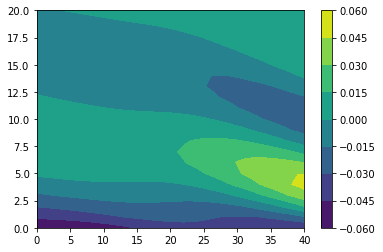

In [34]:
plt.contourf((tu[2])[6])
plt.colorbar()